## Imports

In [1]:
import os
import sys
sys.path.insert(0, "../")

from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
import scipy as sp

from src.energy import cluster_style
from src.energy import data_energy
from src.energy import feature_WCT
from src.energy import style_transfer

#import graph_cut as gc
from maxflow.fastmin import aexpansion_grid

Content shape :  (512, 512, 3)
Style shape :  (512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


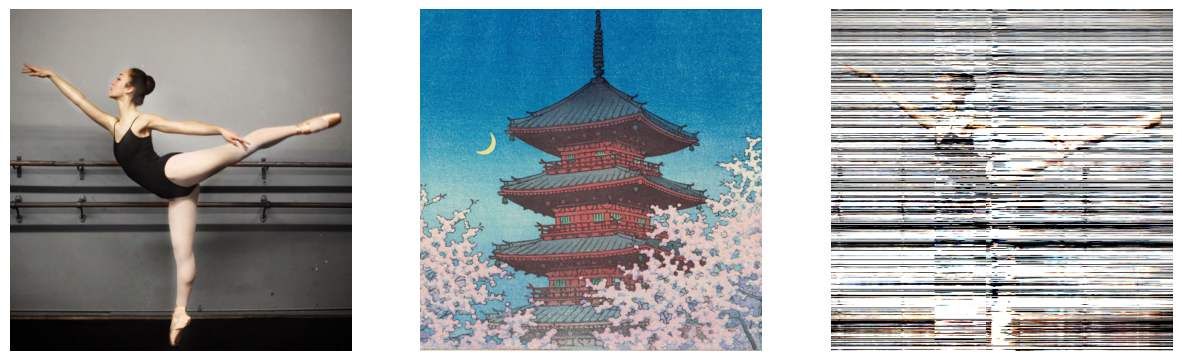

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name, for_plot=True):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    if for_plot:
      image = image.cpu().numpy().transpose(1,2,0)
    return image

content_img = image_loader("../data/images/dance2.png")
style_img = image_loader("../data/images/kawase.png")

print("Content shape : ",content_img.shape)
print("Style shape : ",style_img.shape)


def plot_images(target, initial, assigned):
    """shows both images"""

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(target)
    ax[0].axis('off')
    ax[1].imshow(initial)
    ax[1].axis('off')
    ax[2].imshow(assigned)
    ax[2].axis('off')

    plt.show();

transfered_features = style_transfer(content_img, style_img)

plot_images(content_img, style_img, transfered_features)

Distance array shape :  (3, 512, 512)
Distance image shape :  (512, 512)


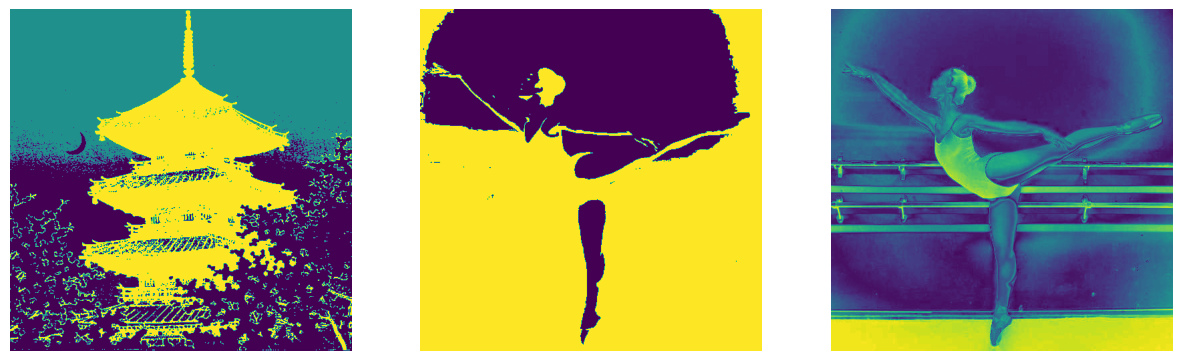

In [77]:
#clustering of style image
n_clusters=3

style_img_flat = style_img.reshape((-1,3))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(style_img_flat)

cluster_labels = kmeans.labels_.reshape((imsize,imsize))
cluster_centers = kmeans.cluster_centers_

# distance of content image to cluster centers

distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
print("Distance array shape : ",distance_array.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances


#greedy assignement
greedy_assignments = np.argmin(distance_array,axis=0)
distance_img = np.zeros((imsize,imsize),dtype=np.float32)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    mask = (greedy_assignments == i)
    distance_img[mask] = distance_array[i][mask]

plot_images(cluster_labels, greedy_assignments, distance_img)

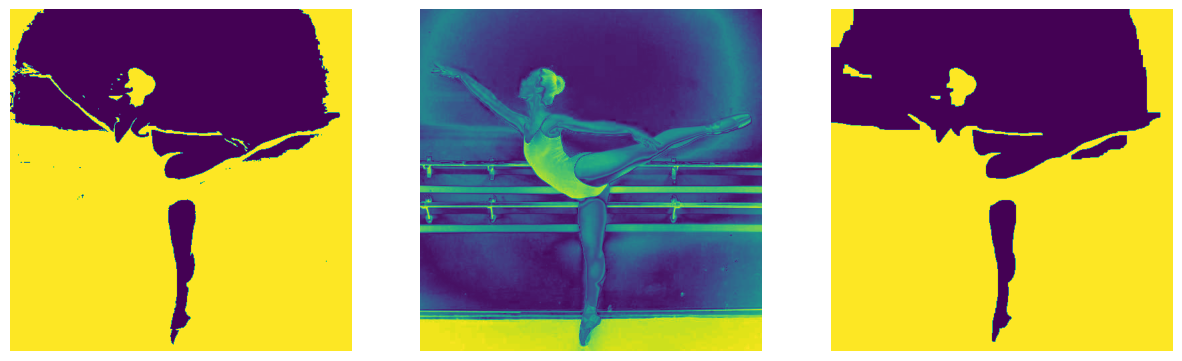

In [92]:
beta = 0.5
smooth_term = beta * (1 - np.eye(n_clusters))
data_term = distance_array.transpose(1,2,0).copy().astype(np.double)

new_assignements = aexpansion_grid(data_term, smooth_term, max_cycles=None)

plot_images(greedy_assignments, distance_img, new_assignements)

(96538, 3)


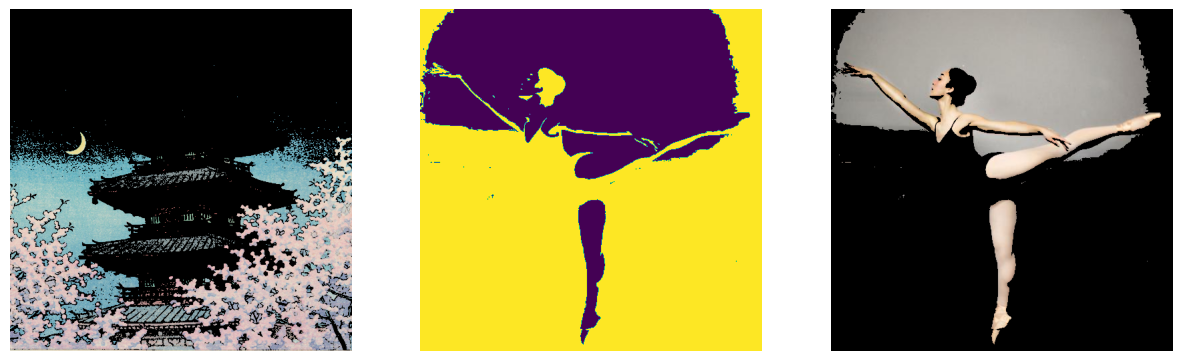

In [93]:
cluster_list = [style_img[cluster_labels == i] for i in range(n_clusters)]
print(cluster_list[0].shape)

cluster_0_style_mask = (cluster_labels == 0)
cluster_0_content_mask = (greedy_assignments == 0)

plot_images((style_img.transpose(2,0,1) * cluster_0_style_mask).transpose(1,2,0), greedy_assignments,(content_img.transpose(2,0,1) * cluster_0_content_mask).transpose(1,2,0))

In [94]:
do_energy_file = True

if do_energy_file:

  transfered_features = np.zeros(content_img.transpose(2,0,1).shape)

  for i in tqdm(range(3)):
      mask = (cluster_labels == i).astype(int) # (height, width)
      print(feature_WCT(content_img.transpose(2,0,1), cluster_list[i], mask, 0.6).shape)
      transfered_features += feature_WCT(content_img.transpose(2,0,1), cluster_list[i], mask, 0.6)

  0%|          | 0/3 [00:00<?, ?it/s]

(3, 512, 512)
(3, 512, 512)
(3, 512, 512)


In [95]:
do_manuel = False

if do_manuel:

  transfered_features = np.zeros((imsize,imsize))

  for i in tqdm(range(3)):
    content_features = content_img.transpose(2,0,1)
    style_features = cluster_list[0].transpose(1,0)
    label = (cluster_labels == 0).astype(int) # (height, width)
    alpha = 0.1

    ###################################""


    channels = content_features.shape[0]
    cluster_size = style_features.shape[0]

    # Compute the mean of the content features
    # Multiply each channel by the label to put to zero the non-content features
    content_mask = content_features * label  # (channel, height, width)
    content_mean = np.mean(content_mask, axis=(1, 2), keepdims=True) * label
    content_features = content_features - content_mean
    content_covariance = np.einsum("ijk,ljk->il", content_features, content_features) / (sum(label.flatten()) / channels - 1)

    # Compute the mean of the style features
    # Multiply each channel by the label to put to zero the non-content features
    style_features = style_features.T  # (height * width, cluster size)
    style_mean = np.mean(style_features, axis=(1,), keepdims=True)
    style_features = style_features - style_mean
    style_covariance = np.einsum("ij,lj->il", style_features, style_features) / (
        cluster_size - 1
    )

    # It can happen that the SVD fails to converge, in this case we return the content features
    try:
        _, content_S, content_V =  sp.linalg.svd(content_covariance)
        _, style_S, style_V =  sp.linalg.svd(style_covariance)
        content_D = np.diag(np.power(content_S, -0.5))
        style_D = np.diag(np.power(style_S, 0.5))

        # Compute the whitening and coloring matrix
        whitening_matrix = content_V @ content_D @ content_V.T
        coloring_matrix = style_V @ style_D @ style_V.T

        style_mean = style_mean[:, np.newaxis]
        style_mean = style_mean * label

        result = (coloring_matrix @ whitening_matrix @ content_features.reshape(channels, -1)).reshape(content_features.shape) + style_mean

        result = result * alpha + content_mask * (1 - alpha)
    except np.linalg.LinAlgError:
        print("SVD failed to converge")
        result = content_features

    print(result.shape)

    transfered_features += result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


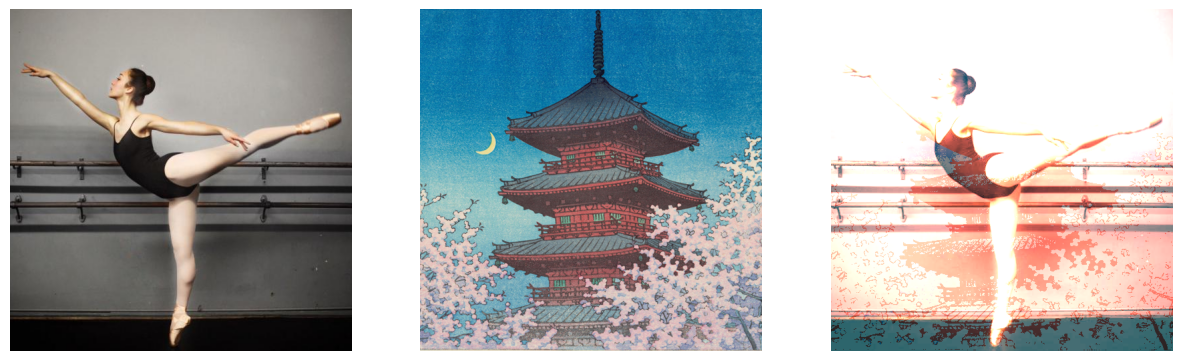

In [96]:
plot_images(content_img, style_img, transfered_features.transpose(1,2,0))